In [1]:
# 207 final project
# dataset: child mind institute - problematic internet use
# kaggle: https://www.kaggle.com/competitions/child-mind-institute-problematic-internet-use/overview

# import necessary libraries
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import History
import warnings

# suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)

# load data
df = pd.read_csv("~/mids/207/final project/train.csv")

In [2]:
# data preprocessing

# drop rows with null target
df = df.dropna(subset=["sii"])

# exclude PCIAT variables
pciat_cols = [col for col in df.columns if "PCIAT" in col]
df = df.drop(columns=pciat_cols)

# handle missing values
for col in df.columns:
    if df[col].dtype == "object":
        df[col].fillna("missing", inplace=True)
    else:
        df[col].fillna(0, inplace=True)

# encode categorical features
from sklearn.preprocessing import LabelEncoder
label_encoders = {}
for column in df.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

print(f"\nValue counts of target variable:\n{df['sii'].value_counts()}")
    
# convert to binary classification
df['sii'] = df['sii'].apply(lambda x: 0 if x == 0 else 1)
print("\nConverting to binary class ...")
print(f"\nValue counts of target variable:\n{df['sii'].value_counts()}")
    
# split data
target = "sii"
features = df.drop(columns=[target])
X_train, X_temp, y_train, y_temp = train_test_split(features, df[target], test_size=0.4, random_state=33)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=33)


Value counts of target variable:
0.0    1594
1.0     730
2.0     378
3.0      34
Name: sii, dtype: int64

Converting to binary class ...

Value counts of target variable:
0    1594
1    1142
Name: sii, dtype: int64


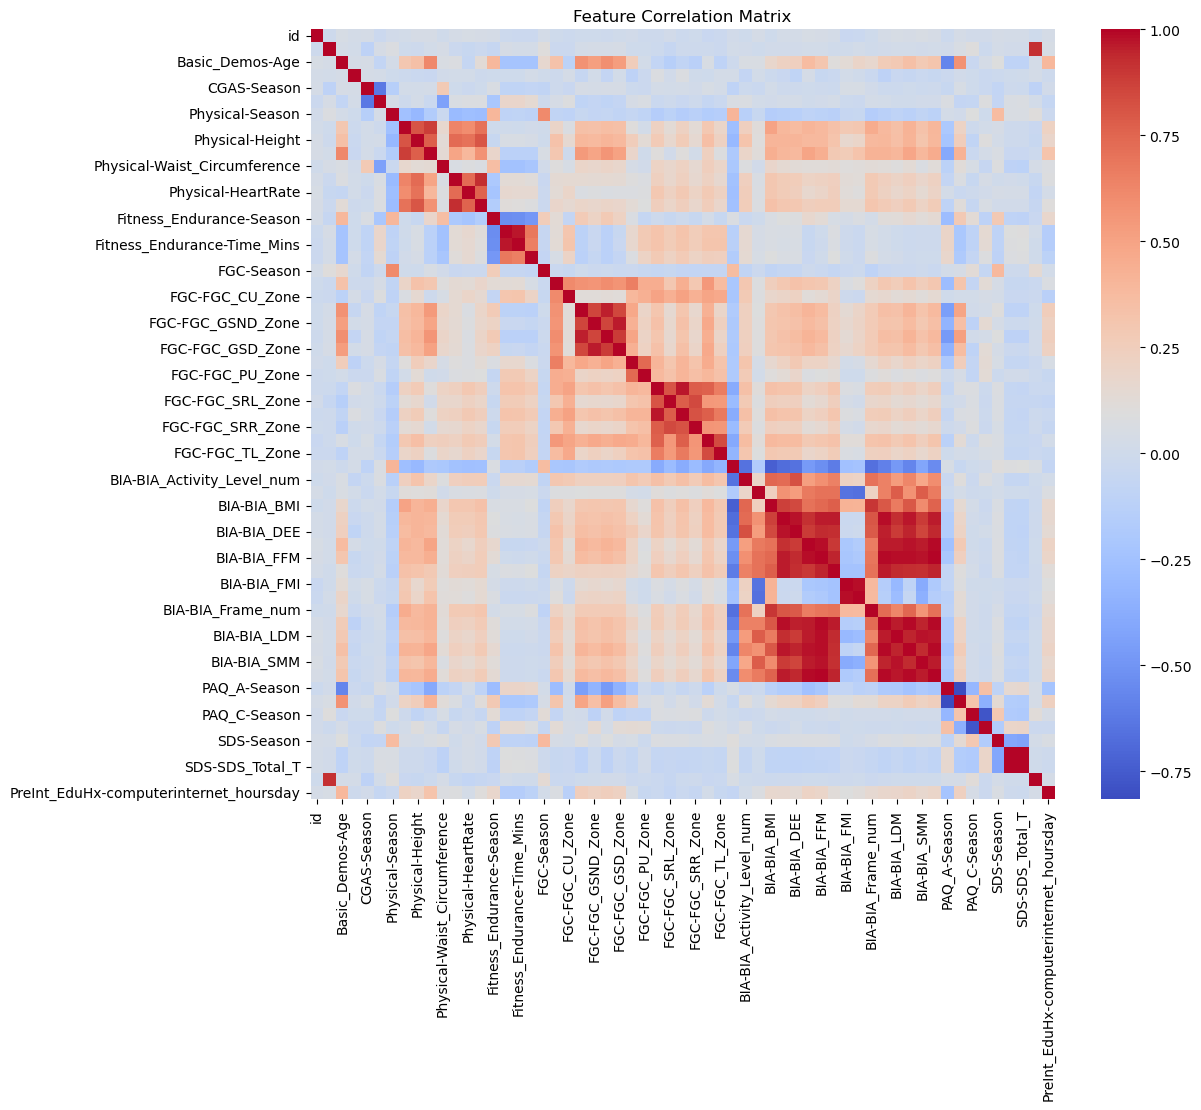


Top 30 Features Using SelectKBest:
                                   Feature     Score
9                          Physical-Weight  0.063499
58  PreInt_EduHx-computerinternet_hoursday  0.055513
2                          Basic_Demos-Age  0.055163
39                             BIA-BIA_ECW  0.050835
37                             BIA-BIA_BMR  0.049175
40                             BIA-BIA_FFM  0.048195
7                             Physical-BMI  0.047619
47                             BIA-BIA_LST  0.044626
11                   Physical-Diastolic_BP  0.043723
46                             BIA-BIA_LDM  0.040673
8                          Physical-Height  0.036420
38                             BIA-BIA_DEE  0.036266
45                             BIA-BIA_ICW  0.036043
23                             FGC-FGC_GSD  0.035724
21                            FGC-FGC_GSND  0.035568
22                       FGC-FGC_GSND_Zone  0.031932
15             Fitness_Endurance-Max_Stage  0.028842
51        

In [3]:
# feature selection

# correlation matrix for features
plt.figure(figsize=(12, 10))
sns.heatmap(X_train.corr(), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Matrix")
plt.show()

# identify numeric features
numeric_cols = features.select_dtypes(include=["float64", "int64"]).columns

# standardize data
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_val[numeric_cols] = scaler.transform(X_val[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# apply selectkbest feature selection after standardization
k = 30
selector = SelectKBest(score_func=mutual_info_classif, k=k)
X_train_selected = selector.fit_transform(X_train, y_train)
X_val_selected = selector.transform(X_val)
X_test_selected = selector.transform(X_test)

# retrieve feature scores and names
feature_scores = selector.scores_  
feature_names = X_train.columns

# combine and sort scores
feature_scores_df = pd.DataFrame({
    "Feature": feature_names,
    "Score": feature_scores
}).sort_values(by="Score", ascending=False)

# print top features
print(f"\nTop {k} Features Using SelectKBest:")
print(feature_scores_df.head(k))

selected_features = features.columns[selector.get_support()]
dropped_features = features.columns[~selector.get_support()]
print(f"\nSelected Features ({k}): {list(selected_features)}")
print(f"\nDropped Features ({len(list(dropped_features))}): {list(dropped_features)}")


Confusion Matrix: Majority Baseline


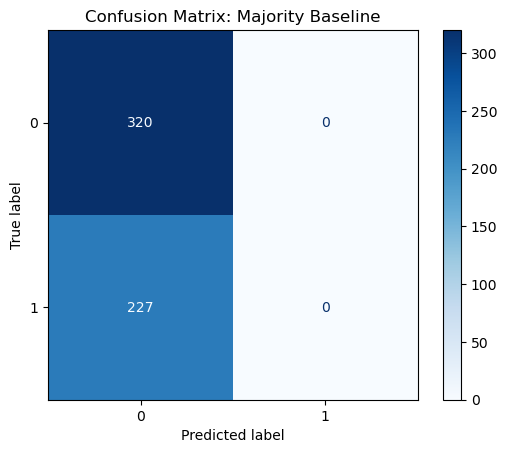

In [4]:
# majority baseline classifier
majority_class = y_train.mode()[0]
y_pred_majority = np.full_like(y_val, fill_value=majority_class)

# binarize the target for ROC AUC
classes = np.unique(y_train)
y_train_binarized = label_binarize(y_train, classes=classes)
y_val_binarized = label_binarize(y_val, classes=classes)
roc_auc_majority = roc_auc_score(y_val_binarized, label_binarize(y_pred_majority, classes=classes), multi_class="ovr")

baseline_summary = {
    "Model": "Majority Baseline",
    "Train Accuracy": accuracy_score(y_train, np.full_like(y_train, fill_value=majority_class)),
    "Val Accuracy": accuracy_score(y_val, y_pred_majority),
    "ROC AUC": roc_auc_majority,
    "Train Time (s)": 0, 
}

# confusion matrix for majority baseline
print("\nConfusion Matrix: Majority Baseline")
cm_majority = confusion_matrix(y_val, y_pred_majority)
disp_majority = ConfusionMatrixDisplay(confusion_matrix=cm_majority, display_labels=classes)
disp_majority.plot(cmap="Blues")
plt.title("Confusion Matrix: Majority Baseline")
plt.show()

print("================================================================")


Training Logistic Regression...
Best Parameters: {'C': 0.1, 'penalty': 'l2'}
Train Accuracy: 0.6946983546617916
Val Accuracy: 0.7367458866544789
ROC AUC (OvR): 0.801238986784141

              precision    recall  f1-score   support

           0       0.75      0.82      0.79       320
           1       0.71      0.61      0.66       227

    accuracy                           0.74       547
   macro avg       0.73      0.72      0.72       547
weighted avg       0.73      0.74      0.73       547



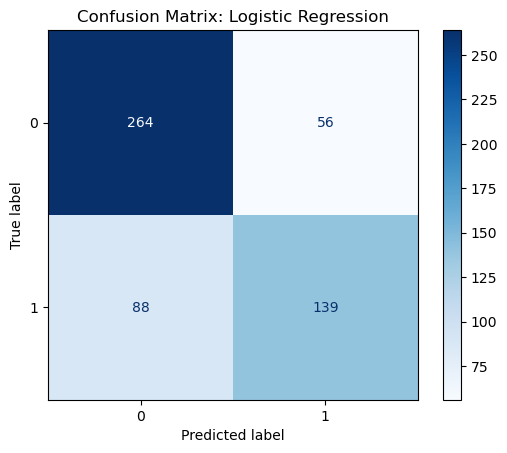


Training Decision Tree...
Best Parameters: {'max_depth': 3, 'min_samples_split': 2}
Train Accuracy: 0.7056672760511883
Val Accuracy: 0.7093235831809872
ROC AUC (OvR): 0.7540473568281939

              precision    recall  f1-score   support

           0       0.73      0.80      0.76       320
           1       0.67      0.59      0.63       227

    accuracy                           0.71       547
   macro avg       0.70      0.69      0.69       547
weighted avg       0.71      0.71      0.71       547



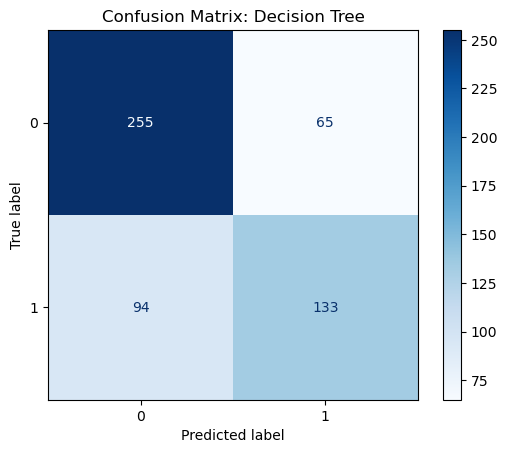


Training Random Forest...
Best Parameters: {'max_depth': 5, 'n_estimators': 500}
Train Accuracy: 0.7501523461304083
Val Accuracy: 0.7221206581352834
ROC AUC (OvR): 0.778703193832599

              precision    recall  f1-score   support

           0       0.74      0.81      0.77       320
           1       0.69      0.60      0.64       227

    accuracy                           0.72       547
   macro avg       0.72      0.70      0.71       547
weighted avg       0.72      0.72      0.72       547



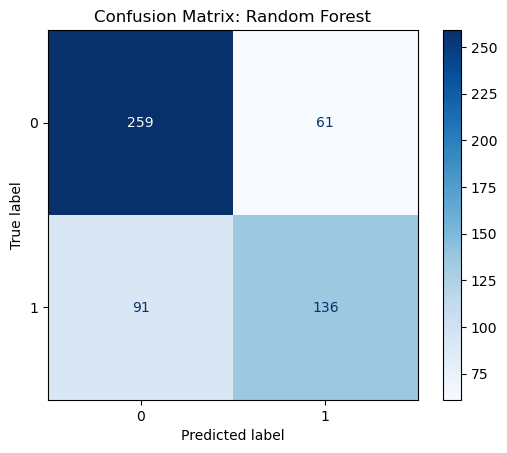


Training Gradient Boosting...
Best Parameters: {'learning_rate': 0.01, 'n_estimators': 200}
Train Accuracy: 0.7404021937842779
Val Accuracy: 0.7239488117001828
ROC AUC (OvR): 0.7797150330396475

              precision    recall  f1-score   support

           0       0.73      0.83      0.78       320
           1       0.70      0.58      0.63       227

    accuracy                           0.72       547
   macro avg       0.72      0.70      0.71       547
weighted avg       0.72      0.72      0.72       547



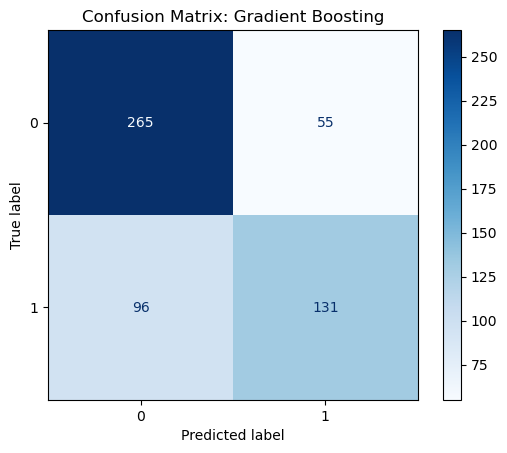


Training XGBoost...
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Train Accuracy: 0.7416209628275442
Val Accuracy: 0.7257769652650823
ROC AUC (OvR): 0.7785999449339207

              precision    recall  f1-score   support

           0       0.73      0.83      0.78       320
           1       0.71      0.57      0.63       227

    accuracy                           0.73       547
   macro avg       0.72      0.70      0.71       547
weighted avg       0.72      0.73      0.72       547



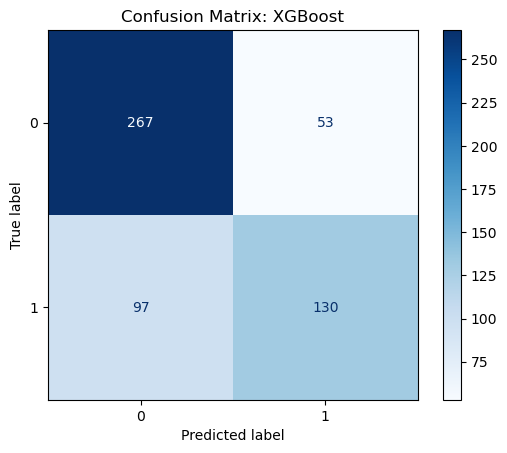

In [5]:
# additional model types

# dictionary to store ROC data for each model
roc_data = {}

# models with hyperparameter tuning
models_with_params = {
    "Logistic Regression": (LogisticRegression(solver="liblinear", multi_class="ovr", max_iter=500), {
        "penalty": ["l2"],
        "C": [0.1, 1, 10],
    }),
    "Decision Tree": (DecisionTreeClassifier(random_state=33), {
        "max_depth": [3, 5, 10],
        "min_samples_split": [2, 5, 10],
    }),
    "Random Forest": (RandomForestClassifier(random_state=33), {
        "n_estimators": [50, 100, 200, 500],
        "max_depth": [5, 10, 20],
    }),
    "Gradient Boosting": (GradientBoostingClassifier(random_state=33), {
        "n_estimators": [50, 100, 200, 500],
        "learning_rate": [0.001, 0.01, 0.1, 0.2],
    }),
    "XGBoost": (XGBClassifier(verbosity=0,
                              disable_default_eval_metric=True,
                              use_label_encoder=False, 
                              eval_metric="logloss", 
                              random_state=42), {
        "n_estimators": [50, 100, 200, 500],
        "learning_rate": [0.001, 0.01, 0.1, 0.2],
        "max_depth": [3, 5, 10],
    }),
}

# store results for summary
summary_results = [baseline_summary]

for name, (model, param_grid) in models_with_params.items():
    print(f"\nTraining {name}...")
    start_time = time.time()

    # hyperparameter tuning
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring="roc_auc_ovr", n_jobs=-1)
    grid_search.fit(X_train_selected, y_train)

    duration = time.time() - start_time
    best_model = grid_search.best_estimator_

    # validation predictions and probabilities
    y_pred_train = best_model.predict(X_train_selected)
    y_pred_val = best_model.predict(X_val_selected)
    y_prob_val = best_model.predict_proba(X_val_selected)

    # metrics
    roc_auc = roc_auc_score(y_val, y_prob_val[:, 1])
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Train Accuracy: {accuracy_score(y_train, y_pred_train)}")
    print(f"Val Accuracy: {accuracy_score(y_val, y_pred_val)}")
    print(f"ROC AUC (OvR): {roc_auc}\n")
    print(classification_report(y_val, y_pred_val))

    # record results
    summary_results.append({
        "Model": name,
        "Train Accuracy": accuracy_score(y_train, y_pred_train),
        "Val Accuracy": accuracy_score(y_val, y_pred_val),
        "ROC AUC": roc_auc,
        "Train Time (s)": duration,
    })

    # store ROC data for combined chart
    fpr, tpr, _ = roc_curve(y_val, y_prob_val[:, 1])
    roc_data[name] = (fpr, tpr, roc_auc)

    # confusion matrix
    cm = confusion_matrix(y_val, y_pred_val)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix: {name}")
    plt.show()
  
    print("================================================================")


Training FF Neural Network...
Epoch 1/100


2024-11-24 19:57:08.004847: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-11-24 19:57:08.004865: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-11-24 19:57:08.004874: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-11-24 19:57:08.004886: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-24 19:57:08.004894: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-11-24 19:57:08.284407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


103/103 - 1s - 14ms/step - accuracy: 0.5210 - loss: 0.7757 - val_accuracy: 0.6417 - val_loss: 0.6420
Epoch 2/100
103/103 - 1s - 7ms/step - accuracy: 0.5826 - loss: 0.7129 - val_accuracy: 0.6728 - val_loss: 0.6241
Epoch 3/100
103/103 - 1s - 7ms/step - accuracy: 0.5777 - loss: 0.6858 - val_accuracy: 0.6764 - val_loss: 0.6162
Epoch 4/100
103/103 - 1s - 7ms/step - accuracy: 0.5820 - loss: 0.6846 - val_accuracy: 0.6782 - val_loss: 0.6166
Epoch 5/100
103/103 - 1s - 7ms/step - accuracy: 0.6039 - loss: 0.6762 - val_accuracy: 0.6709 - val_loss: 0.6127
Epoch 6/100
103/103 - 1s - 7ms/step - accuracy: 0.6124 - loss: 0.6601 - val_accuracy: 0.6892 - val_loss: 0.6057
Epoch 7/100
103/103 - 1s - 7ms/step - accuracy: 0.6228 - loss: 0.6478 - val_accuracy: 0.6965 - val_loss: 0.5995
Epoch 8/100
103/103 - 1s - 7ms/step - accuracy: 0.6185 - loss: 0.6536 - val_accuracy: 0.7057 - val_loss: 0.5974
Epoch 9/100
103/103 - 1s - 7ms/step - accuracy: 0.6149 - loss: 0.6497 - val_accuracy: 0.7112 - val_loss: 0.5904
Epo

Epoch 74/100
103/103 - 1s - 7ms/step - accuracy: 0.6977 - loss: 0.5836 - val_accuracy: 0.7239 - val_loss: 0.5528
Epoch 75/100
103/103 - 1s - 7ms/step - accuracy: 0.6868 - loss: 0.5917 - val_accuracy: 0.7239 - val_loss: 0.5498
Epoch 76/100
103/103 - 1s - 7ms/step - accuracy: 0.6941 - loss: 0.6006 - val_accuracy: 0.7185 - val_loss: 0.5555
Epoch 77/100
103/103 - 1s - 7ms/step - accuracy: 0.6971 - loss: 0.5946 - val_accuracy: 0.7258 - val_loss: 0.5548
Epoch 78/100
103/103 - 1s - 7ms/step - accuracy: 0.6977 - loss: 0.5916 - val_accuracy: 0.7313 - val_loss: 0.5540
Epoch 79/100
103/103 - 1s - 7ms/step - accuracy: 0.6990 - loss: 0.5754 - val_accuracy: 0.7221 - val_loss: 0.5503
Epoch 80/100
103/103 - 1s - 7ms/step - accuracy: 0.7044 - loss: 0.5970 - val_accuracy: 0.7313 - val_loss: 0.5510
Epoch 81/100
103/103 - 1s - 7ms/step - accuracy: 0.6874 - loss: 0.6046 - val_accuracy: 0.7331 - val_loss: 0.5544
Epoch 82/100
103/103 - 1s - 7ms/step - accuracy: 0.6801 - loss: 0.5985 - val_accuracy: 0.7258 - 

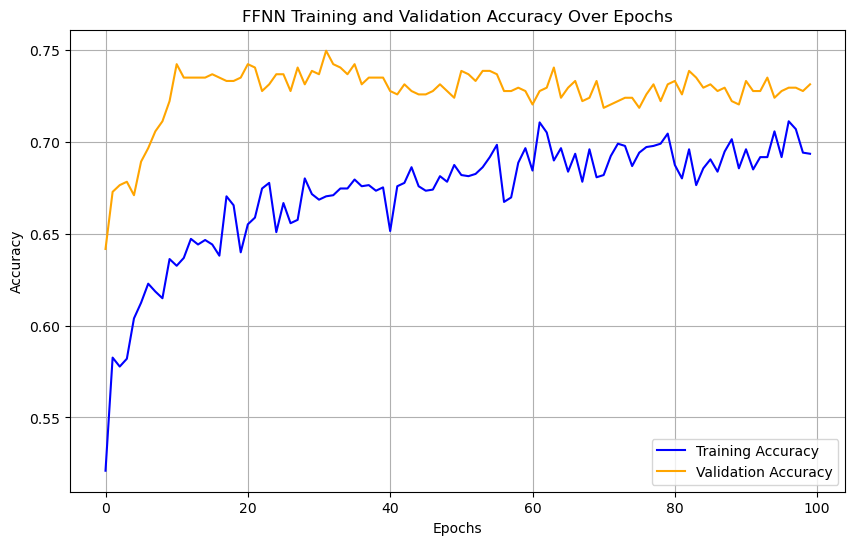

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step

Training Accuracy: 0.7239488117001828
Validation Accuracy: 0.7312614259597806
ROC AUC (OvR): 0.7970264317180615

              precision    recall  f1-score   support

           0       0.76      0.80      0.78       320
           1       0.69      0.63      0.66       227

    accuracy                           0.73       547
   macro avg       0.72      0.72      0.72       547
weighted avg       0.73      0.73      0.73       547



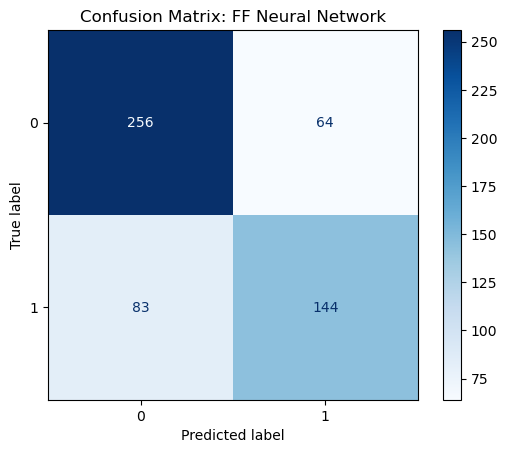

In [6]:
# feedforward neural network
print("\nTraining FF Neural Network...")

# define the FFNN model
input_dim = X_train_selected.shape[1]
model = Sequential([
    Dense(16, activation="relu", input_dim=input_dim),
    Dropout(0.5),
    Dense(16, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# train the FFNN model
start_time = time.time()
history = model.fit(
    X_train_selected, y_train,
    validation_data=(X_val_selected, y_val),
    epochs=100,
    batch_size=16,
    verbose=2
)
duration = time.time() - start_time

# plot training and validation accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('FFNN Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# evaluate FFNN model
y_pred_train = (model.predict(X_train_selected) > 0.5).astype(int)
y_pred_val = (model.predict(X_val_selected) > 0.5).astype(int)
y_prob_val = model.predict(X_val_selected)

roc_auc_fnn = roc_auc_score(y_val, y_prob_val)  # Use probabilities directly
print(f"\nTraining Accuracy: {accuracy_score(y_train, y_pred_train)}")
print(f"Validation Accuracy: {accuracy_score(y_val, y_pred_val)}")
print(f"ROC AUC (OvR): {roc_auc_fnn}\n")
print(classification_report(y_val, y_pred_val))

# record FFNN results
summary_results.append({
    "Model": "FF Neural Network",
    "Train Accuracy": accuracy_score(y_train, y_pred_train),
    "Val Accuracy": accuracy_score(y_val, y_pred_val),
    "ROC AUC": roc_auc_fnn,
    "Train Time (s)": duration,
})

# confusion matrix for FFNN
cm_fnn = confusion_matrix(y_val, y_pred_val)
disp_fnn = ConfusionMatrixDisplay(confusion_matrix=cm_fnn, display_labels=classes)
disp_fnn.plot(cmap="Blues")
plt.title("Confusion Matrix: FF Neural Network")
plt.show()

In [7]:
# display summary results
summary_df = pd.DataFrame(summary_results)
print("\nSummary Results:")
print(summary_df)


Summary Results:
                 Model  Train Accuracy  Val Accuracy   ROC AUC  Train Time (s)
0    Majority Baseline        0.574650      0.585009  0.500000        0.000000
1  Logistic Regression        0.694698      0.736746  0.801239        0.800419
2        Decision Tree        0.705667      0.709324  0.754047        0.593917
3        Random Forest        0.750152      0.722121  0.778703        1.782571
4    Gradient Boosting        0.740402      0.723949  0.779715        3.964913
5              XGBoost        0.741621      0.725777  0.778600        3.041437
6    FF Neural Network        0.723949      0.731261  0.797026       69.842312
